In [6]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

def calculate_metrics(true_values, pred_values):
    mse = round(mean_squared_error(true_values, pred_values),3)
    mae = round(mean_absolute_error(true_values, pred_values),3)
    r_score = round(r2_score(true_values, pred_values),3)

    return {"mse": mse,
            "mae": mae,
            "r_score": r_score,}

In [34]:
import pandas as pd
import os
import sys
sys.path.insert(0, r'C:\work\DrugDiscovery\main_git\XAI_Chem')

from ml_part.random_forest.data_prep.preparation import DataPreparation
from ml_part.random_forest.train import RFTrain

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from hyperopt import space_eval

CSV_PATH = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\remained_features_25.01.csv'
smiles_filepath = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\smiles_to_index.pkl'

dataPreparation = DataPreparation(CSV_PATH)
outliers_features_to_skip = ['FPSA3', 'nHRing', 'PBF', 'distance_between_atoms_in_f_group_centers',
                             'nC', 'TASA', 'f_freedom', 'RPCS', 'avg_atoms_in_cycle', 'cis/trans',
                             'nF', 'naHRing', 'nFARing', 'naRing', 'nFaHRing', 'nFHRing', 'nAHRing',
                             'nFaRing', 'nFAHRing', 'mol_num_cycles', 'nARing', 'dipole_moment']
X, y = dataPreparation.prepare_data_for_RF(is_pKa=True,
                                           use_mandatory_features=True,
                                           is_remove_outliers=True,
                                           is_remove_nan=False,
                                           outliers_features_to_skip=outliers_features_to_skip)

features_to_drop = []
for feature_name in X.columns:
    if "angle" in feature_name.lower() or feature_name in outliers_features_to_skip:
        features_to_drop.append(feature_name)

X = X.drop(features_to_drop, axis=1)

rf_train = RFTrain(X=X, 
                   y=y,
                   smiles_filepath=smiles_filepath,
                   is_pKa=True,
                   k_folds=2)


True
['dipole_moment', 'FPSA3', 'nHRing', 'avg_atoms_in_cycle', 'angle_X1X2R2', 'PNSA5', 'nN', 'angle_R2X2R1', 'nF', 'nFRing', 'tpsa+f', 'f_freedom', 'f_atom_fraction', 'mol_num_cycles', 'nO', 'nFAHRing', 'angle_R1X1R2', 'distance_between_atoms_in_f_group_centers', 'nC', 'PBF', 'nAHRing', 'mol_volume', 'nFaRing', 'f_to_fg', 'GeomShapeIndex', 'cis/trans', 'PPSA5', 'nFHRing', 'angle_X2X1R1', 'nFaHRing', 'RPCS', 'naRing', 'nFARing', 'dihedral_angle', 'naHRing', 'chirality', 'nARing', 'TASA', 'pKa', 'logP']
PNSA5 [37, 38]
f_atom_fraction [124]
mol_volume [127]
logP [82, 83]
Remains rows:172, amount of features: 40


In [4]:
best_hyperparams = rf_train.find_best_params_with_hyperopt()

best_hyperparams = space_eval(rf_train.space, best_hyperparams)

model = rf_train.train(max_depth=best_hyperparams['max_depth'], 
                       max_features=best_hyperparams['max_features'], 
                       min_samples_leaf=best_hyperparams['min_samples_leaf'], 
                       min_samples_split=best_hyperparams['min_samples_split'], 
                       n_estimators=best_hyperparams['n_estimators'])


100%|██████████| 200/200 [05:34<00:00,  1.67s/trial, best loss: 5.913407501070559]
Найкращі гіперпараметри: {'max_depth': 15, 'max_features': 136, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 630}
Mean Squared Error: 0.6194315211934002


In [28]:
y_test = rf_train.y_test
X_test = rf_train.X_test
y_pred = model.predict(X_test)

calculate_metrics(y_test, y_pred)

{'mse': 0.619, 'mae': 0.63, 'r_score': 0.901}

SAVE RF AS JOBLIB

In [29]:
import joblib

save_path_for_rf = r'C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part\random_forest\models_updated_features_train\pKa_rf_all_molecules(with_and_without_angles)_without_30_features_without_outliers_CV2.joblib'

joblib.dump(model, save_path_for_rf)

['C:\\work\\DrugDiscovery\\main_git\\XAI_Chem\\ml_part\\random_forest\\models_updated_features_train\\pKa_rf_all_molecules(with_and_without_angles)_without_30_features_without_outliers_CV2.joblib']

<BarContainer object of 11 artists>

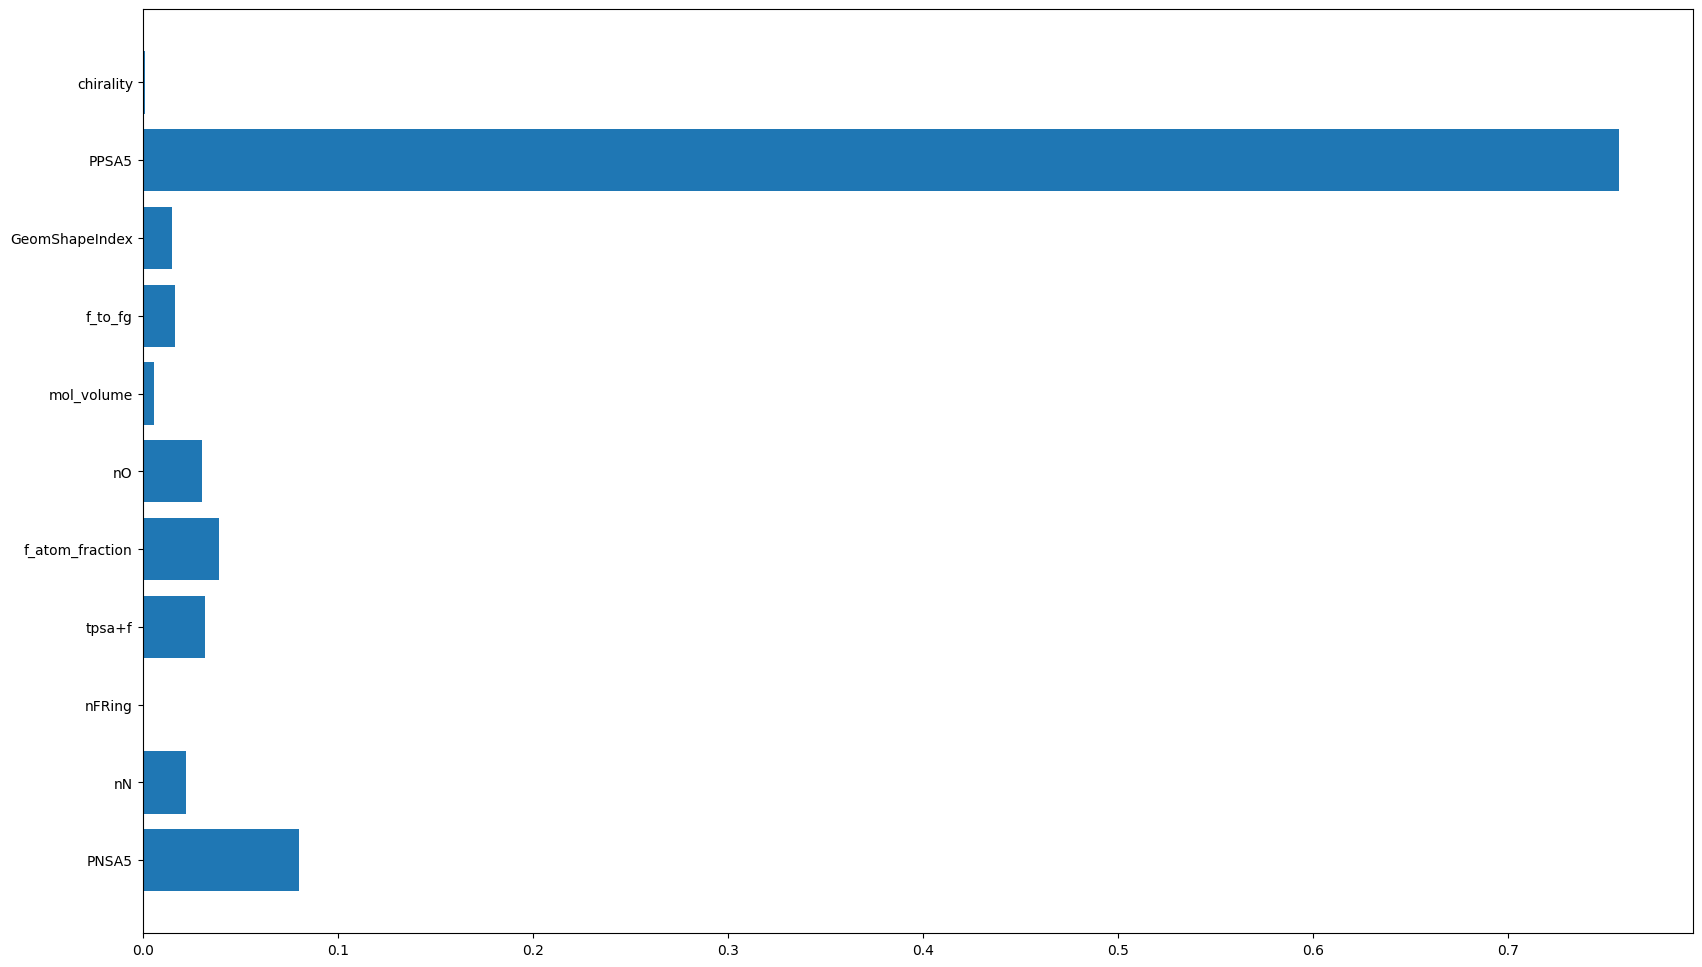

In [30]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,12))
plt.barh(X.columns, model.feature_importances_)

Text(0.5, 0, 'Random Forest Feature Importance')

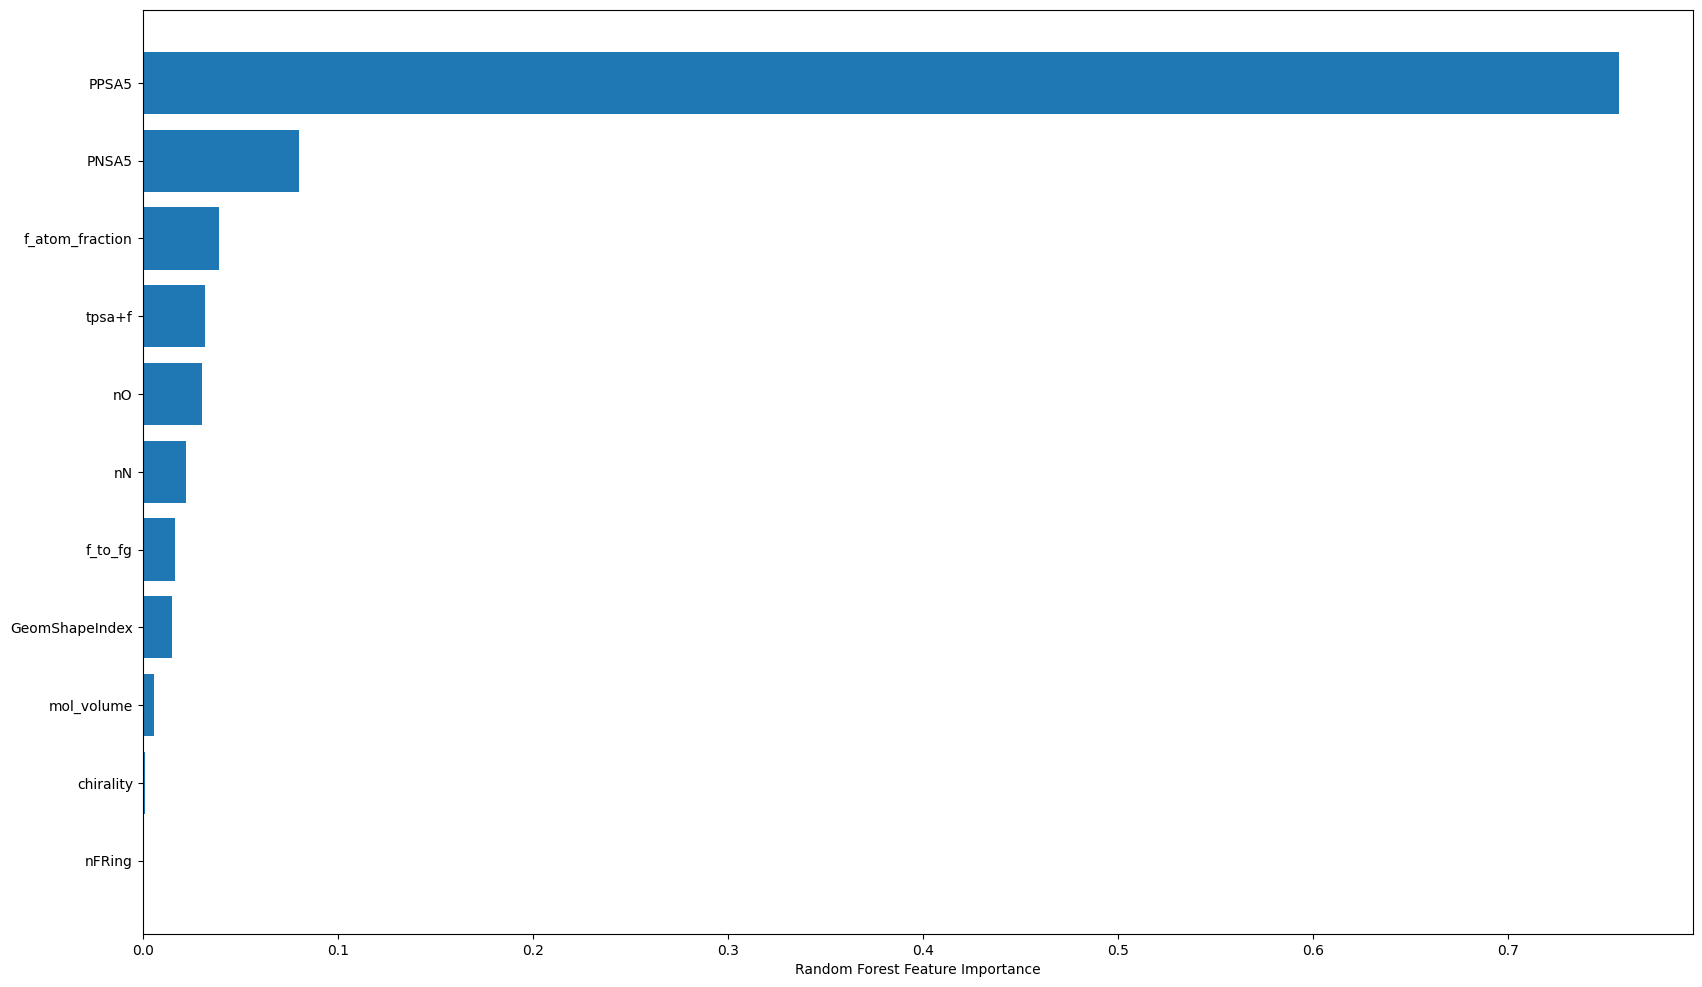

In [23]:
sorted_idx = model.feature_importances_.argsort()
plt.figure(figsize=(20,12))
plt.barh(X.columns[sorted_idx][::-1][:][::-1], model.feature_importances_[sorted_idx][::-1][:][::-1])
plt.xlabel("Random Forest Feature Importance")

Text(0.5, 0, 'Random Forest Feature Importance')

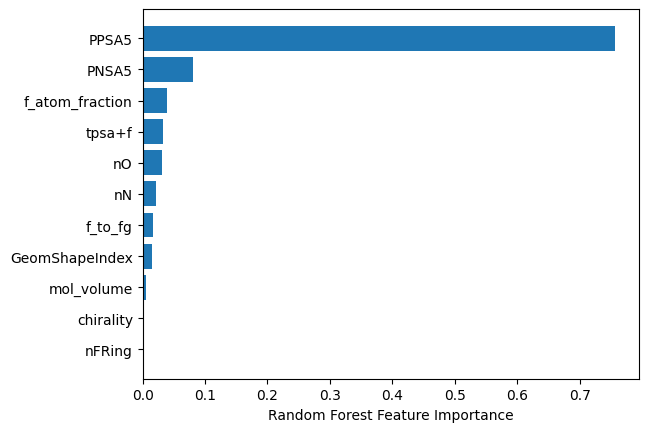

In [10]:
sorted_idx = model.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx][::-1][:15][::-1], model.feature_importances_[sorted_idx][::-1][:15][::-1])
plt.xlabel("Random Forest Feature Importance")

feature permutation

In [13]:
sorted_idx = perm_importance.importances_mean.argsort()
X.columns[sorted_idx]

Index(['nFRing', 'chirality', 'tpsa+f', 'f_to_fg', 'mol_volume',
       'f_atom_fraction', 'GeomShapeIndex', 'nO', 'nN', 'PNSA5', 'PPSA5'],
      dtype='object')

Text(0.5, 0, 'Permutation Importance')

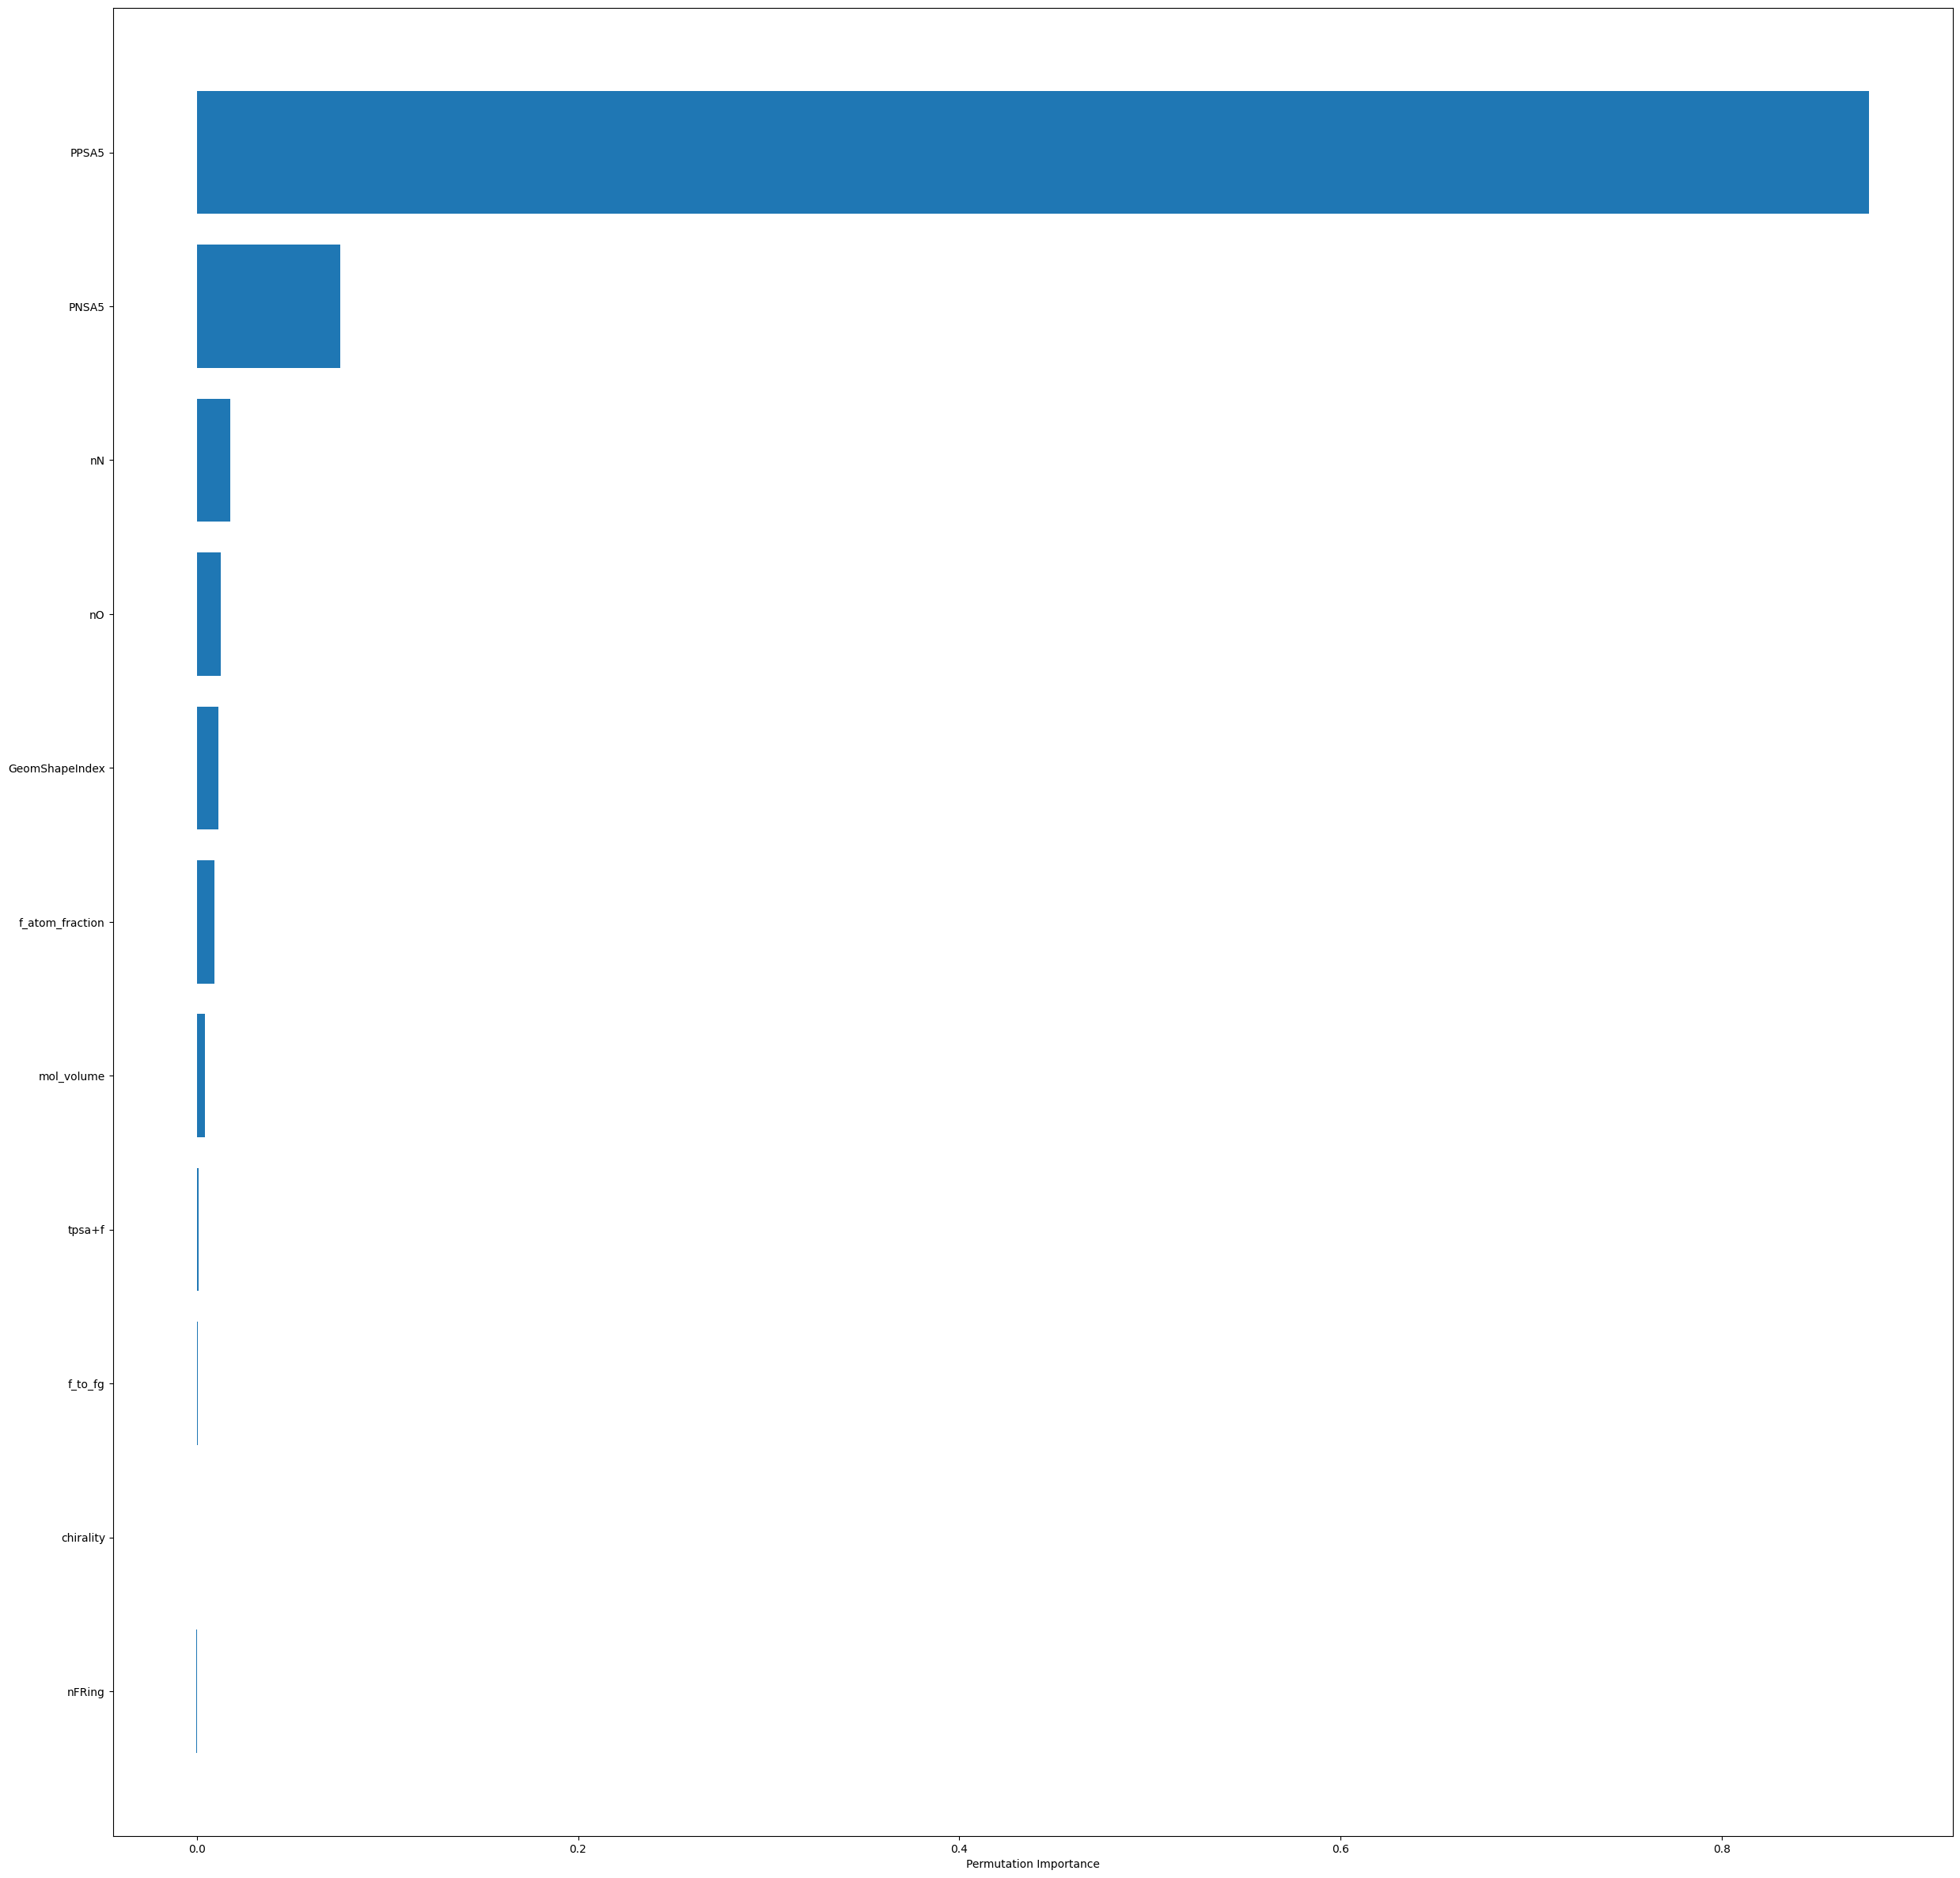

In [35]:
# fine tuned for more than hour
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model, X_test, y_test, n_repeats=100)

sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(30,30))
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

**SHAP**

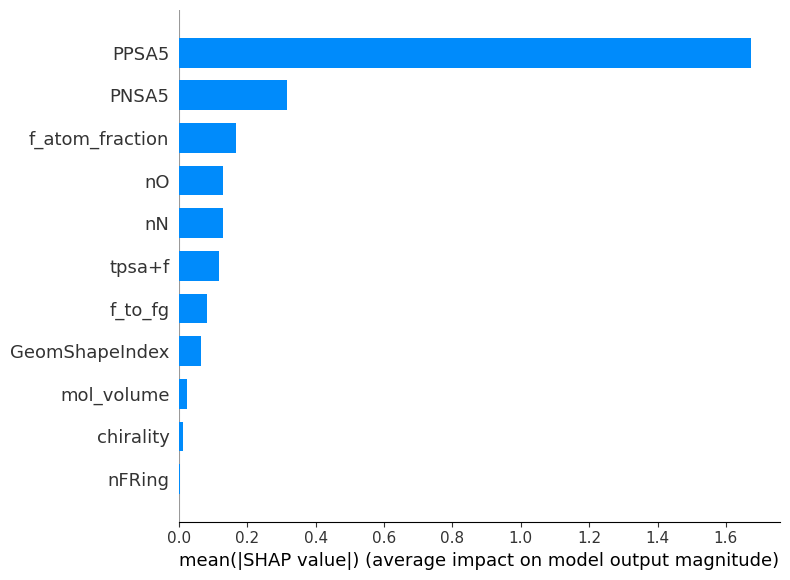

In [32]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")


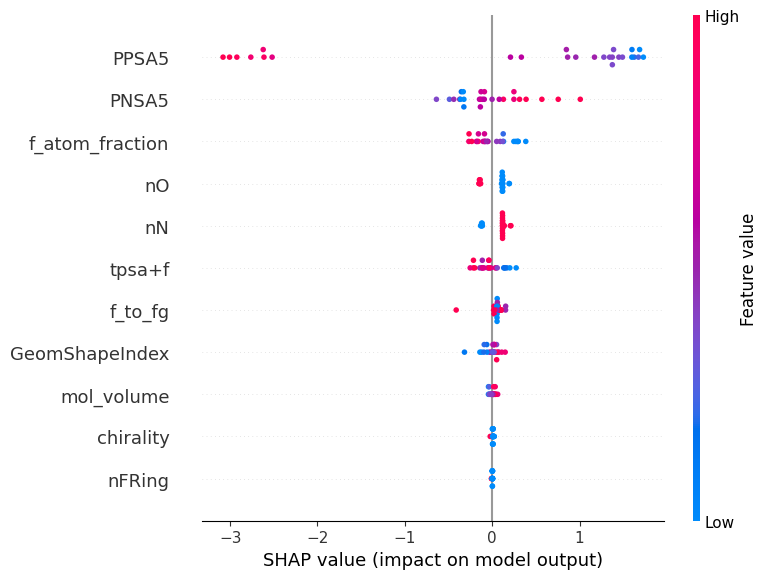

In [33]:
shap.summary_plot(shap_values, X_test)

LOAD LOGP RF

In [12]:
import joblib
from sklearn.model_selection import cross_val_score

model = joblib.load(r"C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part\random_forest\models\logP_rf.joblib")

y_train = rf_train.y_train
X_train = rf_train.X_train

score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
score

array([-0.14847399, -0.10320775, -0.32294882, -0.12681251, -0.1012056 ])